In [1]:
#Keras Model Visualization

from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

# keras => tf.keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import models

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD, Adam
import os
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# 2.2 -  I thought 20201201
# 2.3 or 2.4 - I thought 20201210
# 2.1.2 - 20201228
print (tf.__version__)

2.1.2


In [3]:
batchsize = 10
NUM_EPOCHS = 10
#img_width, img_height = 150, 150
#for VGG 16 use 224 image size
img_width, img_height = 224, 224

## Data
look in TF_sagemaker_install.ipynb  
You'll see the commands to move (kaggle) data from s3 to local directory  

1. get the data from Kaggle, search data - furniture
2. rename archive.zip furniture.zip
3. upload to SageMaker   /home/ec2-user/SageMaker/data

```
unzip furniture.zip
# seems like a redundant directory
rm -rf img
ls furniture-images/img/
```

## 3 or 5 classes
TERRIBLE programming but, add the extra classes here.   Should be redone with functions

    

In [35]:
train_dir = '/home/ec2-user/SageMaker/data/furniture-images/img/train'
val_dir =   '/home/ec2-user/SageMaker/data/furniture-images/img/val'

# train_dir = '/home/ec2-user/SageMaker/data/img/train'
# val_dir =   '/home/ec2-user/SageMaker/data/img/val'

# add the extra classes: 
train_bed_dir = os.path.join(train_dir, 'bed') 
train_chair_dir = os.path.join(train_dir, 'chair')  
train_sofa_dir = os.path.join(train_dir, 'sofa') 
train_swivelchair_dir = os.path.join(train_dir, 'swivelchair')  
train_table_dir = os.path.join(train_dir, 'table') 


val_bed_dir = os.path.join(val_dir, 'bed')  
val_chair_dir = os.path.join(val_dir, 'chair')  
val_sofa_dir = os.path.join(val_dir, 'sofa')  
val_swivelchair_dir = os.path.join(val_dir, 'swivelchair')  
val_table_dir = os.path.join(val_dir, 'table') 

In [36]:
num_bed_train = len(os.listdir(train_bed_dir))
num_chair_train = len(os.listdir(train_chair_dir))
num_sofa_train = len(os.listdir(train_sofa_dir))
num_swivelchair_train = len(os.listdir(train_swivelchair_dir))
num_table_train = len(os.listdir(train_table_dir))

num_bed_val = len(os.listdir(val_bed_dir))
num_chair_val = len(os.listdir(val_chair_dir))
num_sofa_val = len(os.listdir(val_sofa_dir))
num_swivelchair_val = len(os.listdir(val_swivelchair_dir))
num_table_val = len(os.listdir(val_table_dir))

num_train_images = num_bed_train + num_chair_train + num_sofa_train + num_swivelchair_train + num_table_train
num_val_images = num_bed_val + num_chair_val + num_sofa_val + num_swivelchair_val + num_table_val
print(num_train_images, num_val_images)

4024 423


In [37]:
train_datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=90,
      horizontal_flip=True,
      vertical_flip=True
    )

train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(img_height, img_width), 
                                                    batch_size=batchsize)

Found 4024 images belonging to 5 classes.


In [38]:
val_datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=90,
      horizontal_flip=True,
      vertical_flip=True
    )

val_generator = val_datagen.flow_from_directory(val_dir, 
                                                    target_size=(img_height, img_width), 
                                                    batch_size=batchsize)

Found 423 images belonging to 5 classes.


In [39]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


## Create Model

### Memory - OOM Error
I tried running this on a laptop with a GTX 1060 w/ 6 MB, Out of Memory Error!!  
Switched to SageMaker where a p3 has 16 MB (no problem)  



## Model Choice
### custom model - named model
### VGG16 model - named base_model

Choose 1 - PAY CLOSE ATTENTION TO WHAT CELLS TO EXECUTE vs SKIP

custom model: Total params: 714,961,283
VGG16 model:  Total params: 16,292,675

In [10]:
#BUILD A CUSTOM MODEL - SKIP THIS STEP IF YOU USE VGG16.  FOR CUSTOM MODEL USE THIS STEP AND SKIP NEXT TWO STEPS

model = Sequential([
    Conv2D(96, 11, padding='valid', activation='relu', 
           input_shape=(img_height, img_width ,3)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(256, 5, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(384, 3, padding='same', activation='relu'),
    Conv2D(384, 3, padding='same', activation='relu'),
    Conv2D(256, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(1024, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(4096, activation='relu'),
    Dense(3)
])


In [40]:
#BUILD VGG - SKIP CUSTOM MODEL STEP IF YOU USE VGG

base_model = VGG16(weights='imagenet', 
                      include_top=False, 
                      input_shape=(img_height, img_width, 3))

In [41]:
#BUILD VGG - SKIP CUSTOM MODEL STEP IF YOU USE VGG
def build_final_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = True

    x = base_model.output
    
    
    x = GlobalAveragePooling2D()(x)
   
    x = Flatten()(x)
    
    
    # Fine-tune from this layer onwards
    fine_tune_at = 100

    # Freeze all the layers before the `fine_tune_at` layer
    for layer in base_model.layers[:fine_tune_at]:
      layer.trainable =  False

    
    for fc in fc_layers:
        # New FC layer, random init
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)

    # New softmax layer
    predictions = Dense(num_classes, activation='softmax')(x) 
    
    final_model = Model(inputs=base_model.input, outputs=predictions)

    return final_model




class_list = ["bed", "chair", "sofa", "swivelchair", "table"]
FC_LAYERS = [1024, 1024]
dropout = 0.3

model = build_final_model(base_model, 
                                      dropout=dropout, 
                                      fc_layers=FC_LAYERS, 
                                      num_classes=len(class_list))

## NOTE - only run one (1) of the following model.compiles
based on your model selection

In [11]:
#APPLICABLE FOR CUSTOM MODEL
model.compile(optimizer='adam',
            loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
            metrics=['accuracy'])



In [42]:
#APPLICABLE FOR VGG & INCEPTION
adam = Adam(lr=0.00001)
model.compile(adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [43]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

### Page 109l

## Errors:

### VGG16

InvalidArgumentError:  logits and labels must be broadcastable: logits_size=[10,3] labels_size=[10,5]
	 [[node loss/dense_2_loss/softmax_cross_entropy_with_logits (defined at /home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py:1751) ]] [Op:__inference_distributed_function_1831]

Function call stack:  
distributed_function

### Custom Model:

InvalidArgumentError:  Incompatible shapes: [10,3] vs. [10,5]
	 [[node BroadcastGradientArgs_4 (defined at /home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py:1751) ]] [Op:__inference_distributed_function_1698]

Function call stack:  
distributed_function

history = final_model.fit_generator(train_generator, epochs=NUM_EPOCHS, workers=0,
steps_per_epoch=num_train_images // batchsize,
shuffle=True, validation_data=val_generator,
validation_steps=num_val_images // batchsize)

with

history = final_model.fit(train_generator,epochs=NUM_EPOCHS,steps_per_epoch=num_train_images // batchsize,validation_data=val_generator, validation_steps=num_val_images // batchsize)

In [44]:
print (type(train_generator))
print (NUM_EPOCHS)
print (num_train_images)
print(batchsize)
print (type(val_generator))
print (num_val_images)
print (batchsize)

<class 'keras_preprocessing.image.directory_iterator.DirectoryIterator'>
10
4024
10
<class 'keras_preprocessing.image.directory_iterator.DirectoryIterator'>
423
10


In [45]:
print (train_generator.__len__())
print (train_generator.__getitem__(3))

403
(array([[[[ -31.939003 ,   37.221    ,   77.75309  ],
         [ -31.939003 ,   37.221    ,   77.78431  ],
         [ -31.939003 ,   37.221    ,   77.81553  ],
         ...,
         [ -92.0748   ,  -58.135246 ,  -12.906326 ],
         [-103.0699   ,  -77.6481   ,  -34.852753 ],
         [-101.07088  ,  -82.2515   ,  -41.58657  ]],

        [[ -11.547722 ,   57.04586  ,   96.012    ],
         [ -12.671585 ,   55.95321  ,   94.981804 ],
         [ -13.795456 ,   54.860558 ,   93.95159  ],
         ...,
         [ -92.730385 ,  -59.165455 ,  -13.99897  ],
         [-103.00746  ,  -77.71054  ,  -35.008842 ],
         [-101.00844  ,  -82.50125  ,  -41.86753  ]],

        [[ -29.895226 ,   38.83071  ,   75.23191  ],
         [ -28.022118 ,   40.6726   ,   77.16744  ],
         [ -26.14901  ,   42.51449  ,   79.10299  ],
         ...,
         [ -93.38597  ,  -60.195663 ,  -15.091614 ],
         [-102.94503  ,  -77.77297  ,  -35.16494  ],
         [-100.94601  ,  -82.751    ,  -42.1485 

In [46]:
print (val_generator.__len__())
print (val_generator.__getitem__(3))

43
(array([[[[ 65.92152   ,  79.08152   ,  84.18052   ],
         [ 65.19529   ,  78.35529   ,  83.45429   ],
         [ 65.061     ,  78.221     ,  83.32      ],
         ...,
         [ 37.060997  ,  53.221     ,  60.32      ],
         [ 37.060997  ,  53.221     ,  60.32      ],
         [ 37.060997  ,  53.221     ,  60.32      ]],

        [[ 66.061     ,  79.221     ,  84.32      ],
         [ 65.88276   ,  79.04276   ,  84.14176   ],
         [ 65.15653   ,  78.316536  ,  83.415535  ],
         ...,
         [ 37.060997  ,  53.221     ,  60.32      ],
         [ 37.060997  ,  53.221     ,  60.32      ],
         [ 37.060997  ,  53.221     ,  60.32      ]],

        [[ 66.061     ,  79.221     ,  84.32      ],
         [ 66.061     ,  79.221     ,  84.32      ],
         [ 65.844     ,  79.004005  ,  84.103004  ],
         ...,
         [ 37.060997  ,  53.221     ,  60.32      ],
         [ 37.060997  ,  53.221     ,  60.32      ],
         [ 37.060997  ,  53.221     ,  60.32     

In [47]:
history = model.fit(train_generator,epochs=NUM_EPOCHS,steps_per_epoch=num_train_images // batchsize,validation_data=val_generator, validation_steps=num_val_images // batchsize)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 402 steps, validate for 42 steps
Epoch 1/10
402/402 [==============================] - 57s 142ms/step - loss: 2.2181 - accuracy: 0.4056 - val_loss: 0.8825 - val_accuracy: 0.6762
Epoch 2/10
402/402 [==============================] - 55s 137ms/step - loss: 1.2151 - accuracy: 0.6248 - val_loss: 0.7058 - val_accuracy: 0.7452
Epoch 3/10
402/402 [==============================] - 55s 137ms/step - loss: 0.9831 - accuracy: 0.6931 - val_loss: 0.7166 - val_accuracy: 0.7643
Epoch 4/10
402/402 [==============================] - 55s 137ms/step - loss: 0.7934 - accuracy: 0.7451 - val_loss: 0.6069 - val_accuracy: 0.8071
Epoch 5/10
402/402 [==============================] - 55s 137ms/step - loss: 0.7512 - accuracy: 0.7593 - val_loss: 0.5501 - val_accuracy: 0.8119
Epoch 6/10
402/402 [==============================] - 55s 137ms/step - loss: 0.6816 - accuracy: 0.7770 - val_loss: 0.5515 - val_accuracy: 0.8143
Epoch 7/10
402/402 [=================

In [28]:
print(len(model.layers))

26


## Test the model
there is no test data

In [48]:
test_bed = os.path.join(val_dir, 'bed', '00000937.jpg')  
test_chair = os.path.join(val_dir, 'chair', '00000037.jpg')  
test_sofa = os.path.join(val_dir, 'sofa', '00000237.jpg')  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 224, 224, 3)


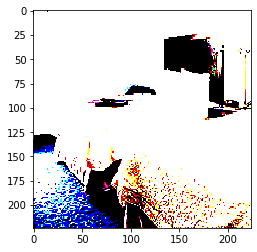

In [49]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline

img_path = test_bed
img = image.load_img(img_path, target_size=(img_height, img_width))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor = preprocess_input(img_tensor)

featuremap = model.predict(img_tensor)
plt.imshow(featuremap)
plt.imshow(img_tensor[0])
print (img_tensor.shape)

In [50]:
from tensorflow.keras.models import Model
layer_outputs = [layer.output for layer in model.layers[:len(model.layers)]]
activation_modelfig = Model(inputs=model.input, outputs=layer_outputs)
activationsfig = activation_modelfig.predict(img_tensor)

(1, 224, 224, 3)


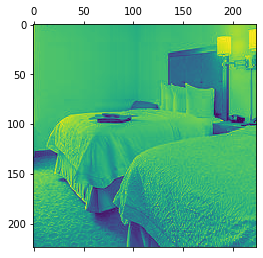

In [51]:
first_layer_activation = activationsfig[0]
print(first_layer_activation.shape)
plt.matshow(first_layer_activation[0, :, :, 2], cmap='viridis')

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:14: MatplotlibDeprecationWarning: Adding an axes 

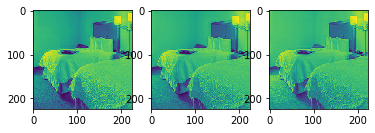

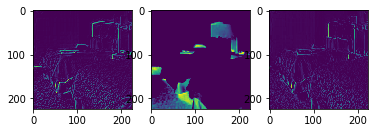

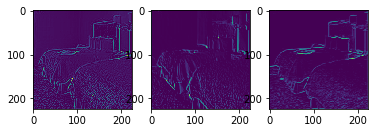

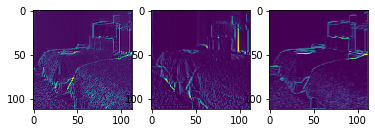

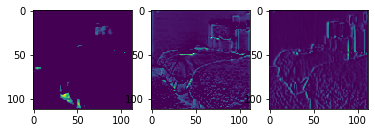

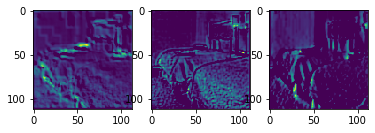

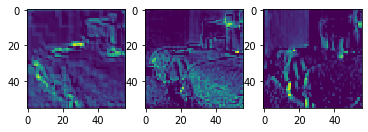

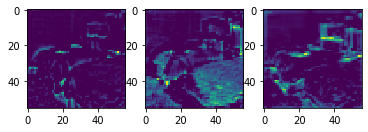

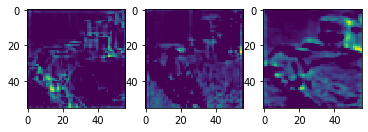

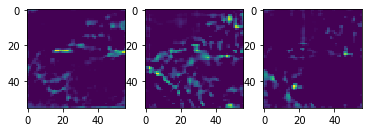

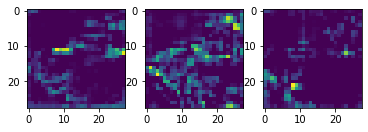

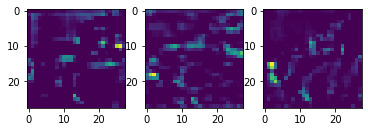

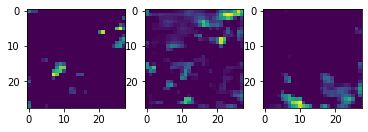

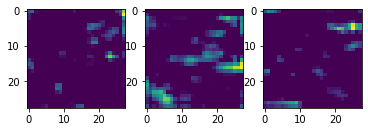

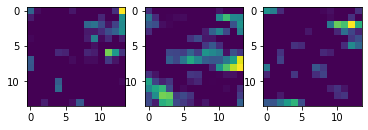

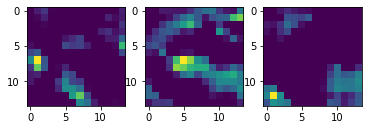

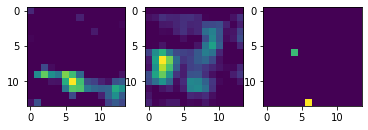

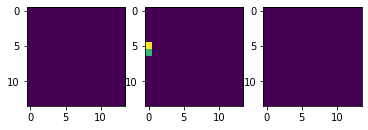

In [52]:
for i in range(0,len(model.layers)-8):
    current_layer_activation = activationsfig[i]
    ns = current_layer_activation.shape[-1]
    fig = plt.figure()
    ax1 = fig.add_subplot(131)
    plt.subplot(131)
    plt.imshow(current_layer_activation[0, :, :, 0], cmap='viridis')
    
    ax3 = fig.add_subplot(132)
    plt.subplot(132)
    plt.imshow(current_layer_activation[0, :, :, int(ns/2)], cmap='viridis')
    
    ax5 = fig.add_subplot(133)
    plt.subplot(133)
    plt.imshow(current_layer_activation[0, :, :, ns-1], cmap='viridis')
    